**Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
# %cd /gdrive/MyDrive/AN2DL/Homework2

### Configurations

**Get Data Sets**

In [2]:
!wget -q https://storage.googleapis.com/storage.barbiero.dev/AN2DL/Homework_2/training_data_clean.npy
!wget -q https://storage.googleapis.com/storage.barbiero.dev/AN2DL/Homework_2/categories_clean.npy
!wget -q https://storage.googleapis.com/storage.barbiero.dev/AN2DL/Homework_2/series_length_clean.npy

**Update Tensorflow**

In [3]:
!pip install --upgrade tensorflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.7 MB/s eta 0:00:00


**Imports**

In [4]:
# Deafault Imports
import os
import logging
import warnings as wr
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tkl
from keras import models as tkm
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# from statsmodels.tsa.seasonal import seasonal_decompose
# from dateutil.parser import parse
# from statsmodels.tsa.stattools import adfuller

**Randomness & Warinings**

In [61]:
# Random Configuration - All
RND = True
if not RND:
  SEED = 42
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Plotting Configuration
plt.rc('font', size=16)

**TPU Config**

In [62]:
use_tpu = True

if 'COLAB_TPU_ADDR' in os.environ and use_tpu:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  use_tpu = False

if use_tpu:
  tpu_address = TF_MASTER
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)

**Initiate Data Sets**

In [63]:
# # Loading Datasets RAW
# TD = np.load("/gdrive/MyDrive/AN2DL/Homework2/training_data.npy", allow_pickle=True)
# VP = np.load("/gdrive/MyDrive/AN2DL/Homework2/valid_periods.npy", allow_pickle=True)
# CG = np.load("/gdrive/MyDrive/AN2DL/Homework2/categories.npy", allow_pickle=True)

# Loading Datasets CLEAN
TD = np.load("training_data_clean.npy", allow_pickle=True)
VP = np.load("series_length_clean.npy", allow_pickle=True)
CG = np.load("categories_clean.npy", allow_pickle=True)

**Data Frame**

In [86]:
# Create Dataframe Unified CLEAN
DATA = []

for i, l in enumerate(VP):
  ts_clipped = TD[i, :l]
  DATA.append(ts_clipped)

df = pd.DataFrame({
    'TimeSeries': [ts.tolist() for ts in DATA],
    'Category': CG.flatten(),
    'Length': VP.flatten()
})
df['Category'] = df['Category'].map({0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F'})

dft = df['TimeSeries']
dfc = df['Category']

print(df['Category'].value_counts())

B    10816
E    10812
C     9893
D     9886
A     5665
F      268
Name: Category, dtype: int64


**Stats of the Data**

In [65]:
df_cat = pd.DataFrame()
dd = pd.DataFrame()
# Avarage Length
avg_length_cat = df.groupby('Category')['Length'].mean().round(2)
df_cat['AVG Length'] = avg_length_cat

# Less than 50 Elements
threshold = 50
df_cat['Below 50 (pcs)'] = df.groupby('Category')['Length'].apply(lambda x: (x < threshold).sum())
df_cat['Below 50 (%)'] = df.groupby('Category')['Length'].apply(lambda x: (x<threshold).mean()*100).round(2)

# Less than 75 Elements
threshold = 75
df_cat['Below 75 (pcs)'] = df.groupby('Category')['Length'].apply(lambda x: (x<threshold).sum())
df_cat['Below 75 (%)'] = df.groupby('Category')['Length'].apply(lambda x: (x<threshold).mean()*100).round(2)

# Less than 100 Elements
threshold = 100
df_cat['Below 100 (pcs)'] = df.groupby('Category')['Length'].apply(lambda x: (x<threshold).sum())
df_cat['Below 100 (%)'] = df.groupby('Category')['Length'].apply(lambda x: (x<threshold).mean()*100).round(2)

# Less than 150 Elements
threshold = 150
df_cat['Below 150 (pcs)'] = df.groupby('Category')['Length'].apply(lambda x: (x<threshold).sum())
df_cat['Below 150 (%)'] = df.groupby('Category')['Length'].apply(lambda x: (x<threshold).mean()*100).round(2)

# Less than 200 Elements
threshold = 200
df_cat['Below 200 (pcs)'] = df.groupby('Category')['Length'].apply(lambda x: (x<threshold).sum())
df_cat['Below 200 (%)'] = df.groupby('Category')['Length'].apply(lambda x: (x<threshold).mean()*100).round(2)

# Less than 218 Elements
threshold = 218
df_cat['Below 218 (pcs)'] = df.groupby('Category')['Length'].apply(lambda x: (x<threshold).sum())
df_cat['Below 218 (%)'] = df.groupby('Category')['Length'].apply(lambda x: (x<threshold).mean()*100).round(2)

# Less than 536 Elements
threshold = 536
df_cat['Below 536 (pcs)'] = df.groupby('Category')['Length'].apply(lambda x: (x<threshold).sum())
df_cat['Below 536 (%)'] = df.groupby('Category')['Length'].apply(lambda x: (x<threshold).mean()*100).round(2)

print(df_cat[['AVG Length']])
print()
print(df_cat[['Below 50 (pcs)', 'Below 50 (%)']])
print(df_cat[['Below 75 (pcs)', 'Below 75 (%)']])
print(df_cat[['Below 100 (pcs)', 'Below 100 (%)']])
print(df_cat[['Below 150 (pcs)', 'Below 150 (%)']])
print(df_cat[['Below 200 (pcs)', 'Below 200 (%)']])
print(df_cat[['Below 218 (pcs)', 'Below 218 (%)']])
print(df_cat[['Below 536 (pcs)', 'Below 536 (%)']])

          AVG Length
Category            
A             278.26
B             165.78
C             206.98
D             216.64
E             162.51
F             195.06

          Below 50 (pcs)  Below 50 (%)
Category                              
A                      1          0.02
B                   1699         15.71
C                    181          1.83
D                     67          0.68
E                     28          0.26
F                     37         13.81
          Below 75 (pcs)  Below 75 (%)
Category                              
A                     46          0.81
B                   3641         33.66
C                   2104         21.27
D                   2653         26.84
E                   4761         44.03
F                     66         24.63
          Below 100 (pcs)  Below 100 (%)
Category                                
A                     163           2.88
B                    3895          36.01
C                    2560          25.88
D 

**Category Dataframes**

In [66]:
# Dataframes
df_A = df[df['Category'] == 'A']
df_B = df[df['Category'] == 'B']
df_C = df[df['Category'] == 'C']
df_D = df[df['Category'] == 'D']
df_E = df[df['Category'] == 'E']
df_F = df[df['Category'] == 'F']

df_AB = pd.concat([df_A, df_B], ignore_index=True)

### Functions ###

In [67]:
# Time Series Plot Functions
def print_timeseries(n, random, norm):
  for i in range(n):
    if random:
      j = np.random.randint(0,len(df))
    else:
      j=i
    print(dfc[j], "Length: ",len(dft[j]))
    if norm:
      plt.plot(range(len(dft[j])), [x*100 for x in dft[j]], label=f'Time Series {i + 1}')
    else:
      plt.plot(range(len(dft[j])), dft[j], label=f'Time Series {i + 1}')

    plt.title(f'#{j}')
    plt.xlabel('Time Index')
    plt.ylabel('Value')
    # plt.legend()
    plt.show()

    return j
def print_category(n, rows, cols, category):
  indices = []

  if n > rows*cols:
    print("Please add more rooms")
    return

  fig, axes = plt.subplots(rows, cols, figsize=(15*cols,5*rows))
  for i in range(n):
    j = np.random.randint(0, len(df))

    while dfc[j] != category or j in indices:
      j = np.random.randint(0, len(df))

    row_i = i // cols
    col_i = i % cols

    print(dfc[j], "Length: ",len(dft[j]))
    axes[row_i, col_i].plot(range(len(dft[j])), dft[j], label=f'Time Series {i + 1}')
    axes[row_i, col_i].set_title(f'#{j}')
    axes[row_i, col_i].set_xlabel('Time Index')
    axes[row_i, col_i].set_ylabel('Value')

    indices.append(j)

  plt.tight_layout()
  plt.show()


In [68]:
def inspect_multivariate_prediction(X, y, pred, telescope, to_print):
    figs, axs = plt.subplots(to_print, 1, sharex=True, figsize=(17, 17))
    n_elements = X.shape[0]
    for i in range(to_print):
        el = rnd.randrange(n_elements)
        axs[i].plot(np.arange(len(X[el, :, 0])), X[el, :, 0])
        axs[i].plot(np.arange(len(X[el, :, 0]) - 1, len(X[el, :, 0]) + telescope - 1), y[el, :, 0], color='orange')
        axs[i].plot(np.arange(len(X[el, :, 0]) - 1, len(X[el, :, 0]) + telescope - 1), pred[el, :], color='green')
        axs[i].set_ylim(0, 1)
    plt.show()

In [69]:
def plot_window_telescope(to_print, X, y, y_pred=None):

    figs, axs = plt.subplots(to_print, 1, sharex=True, figsize=(17, 17))
    for i in range(to_print):
        # connect window and telescope
        y[i] = np.concatenate((X[i][-1:], y))
        # plot window and telescope
        axs[i].plot(np.arange(len(X[i])), X[i], label="window")
        axs[i].plot(np.arange(len(X[i]) - 1, len(X[i]) - 1 + len(y[i])), y[i], label="telescope")
        if y_pred is not None:
            y_pred[i] = np.concatenate((X[i][-1:], y_pred[i]))
            axs[i].plot(np.arange(len(X[i]) - 1, len(X[i]) - 1 + len(y_pred[i])), y_pred[i],
                    label="predicted telescope")
    plt.show()

In [70]:
def augmentation_hflip(df):
  temp = df.copy()
  df['TimeSeries'] = df['TimeSeries'].apply(lambda x: np.flip(x))
  #print(temp, df)
  df = pd.concat([temp, df], ignore_index=True)
  return df

def augmentation_vflip(df):
  temp = df.copy()
  df['TimeSeries'] = df['TimeSeries'].apply(lambda x: [1.0 - value for value in x])
  #print(temp, df)
  df = pd.concat([temp, df], ignore_index=True)
  return df

# df = augmentation_hflip(df)
# df = augmentation_hflip(df)
# print(df)

In [85]:
# "Augmentation" CLEAN
def build_sequence(df, window=200, stride=200, telescope=18, mask_value=-1):
  actual_window = window + telescope
  new_categories = []
  X = []                                                                        # 2d (number of series, window size)
  y = []                                                                        # 2d (number of series, telescope)

  for i in range(len(df)):
    ts = df['TimeSeries'][i]
    length = df['Length'][i]
    category = df['Category'][i]

    new_stride = stride
    n_windows = int(np.ceil((length - actual_window) / new_stride)) + 1         # number of windows
    if n_windows < 1:
      n_windows = 1
    if n_windows > 1:                                                           # evalute the stride again
      new_stride = int((length - actual_window) / (n_windows - 1))

    start_idx = length - actual_window                                          # start from the end of the series
    end_idx = length
    for j in range(n_windows):
      if start_idx < 0:
        start_idx = 0
        end_idx = actual_window
        if end_idx > length:
          end_idx = length

      temp = ts[start_idx:end_idx - telescope]
      if len(temp) < window:
        temp = np.pad(temp, (0, window - len(temp)), mode="constant", constant_values=mask_value)

      X.append(temp)
      y.append(ts[end_idx - telescope:end_idx])
      new_categories.append(category)

      start_idx -= new_stride
      end_idx -= new_stride

  return np.array(X), np.array(y), new_categories


In [72]:
def build_CONV_LSTM_model(input_shape, output_shape, mask_flag, mask_value):
    assert input_shape[0] >= output_shape[0], "For this exercise, we want input time steps to be >= of output time steps"

    input_layer = tkl.Input(shape=input_shape, name='input_layer')
    if mask_flag:
      x = tkl.Masking(mask_value=mask_value)(input_layer)
      x = tkl.Bidirectional(tkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(x)
    else:
      x = tkl.Bidirectional(tkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)
    x = tkl.Bidirectional(tkl.LSTM(256, return_sequences=True, name='lstm'), name='bidirectional_lstm_2')(x)

    # Use GlobalAveragePooling1D before Dense layers
    x = tkl.Conv1D(512, 3, padding='same', activation='relu', name='conv_1')(x)
    x = tkl.Conv1D(256, 3, padding='same', activation='relu', name='conv_2')(x)
    x = tkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    x = tkl.GlobalAveragePooling1D()(x)

    x = tkl.Dense(units=512, activation='relu')(x)
    x = tkl.Dense(units=256, activation='relu')(x)
    x = tkl.Dense(units=128, activation='relu')(x)

    # Output layer without Cropping1D
    output_layer = tkl.Dense(units = output_shape[0])(x)

    output_layer = tkl.Reshape((-1, 1))(output_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

### Training ###

- A -> 218
- B -> 75/100
- C -> 150
- D -> 100/150
- E -> 75/100
- F -> 150

In [87]:
XTR, XTE = train_test_split(df, test_size=0.20, stratify=df['Category'], random_state=SEED)
XTR = XTR.reset_index(drop=True)
XTE = XTE.reset_index(drop=True)

print(XTR, XTE)

                                              TimeSeries Category  Length
0      [0.34626659768925677, 0.34626659768925677, 0.3...        C     216
1      [0.10835214446952596, 0.1162528216704289, 0.11...        D     276
2      [0.7145601908085069, 0.5498995163534374, 1.0, ...        B      49
3      [1.0, 0.9945708376421923, 0.9829369183040331, ...        D     172
4      [0.3700787401574803, 0.25984251968503935, 0.30...        E      51
...                                                  ...      ...     ...
37867  [0.014793502206422296, 0.08681804393628484, 0....        C     134
37868  [0.71280276816609, 0.671280276816609, 0.598615...        E      51
37869  [0.04040720438527799, 0.04040720438527799, 0.0...        C     216
37870  [0.0, 0.03389830508474576, 0.03389830508474576...        C     214
37871  [0.0, 0.00164606343928495, 0.00109737562618996...        C     564

[37872 rows x 3 columns]                                              TimeSeries Category  Length
0     [0.1936

In [88]:
XTR = augmentation_hflip(XTR)
XTR = augmentation_vflip(XTR)
print(XTR)

                                               TimeSeries Category  Length
0       [0.34626659768925677, 0.34626659768925677, 0.3...        C     216
1       [0.10835214446952596, 0.1162528216704289, 0.11...        D     276
2       [0.7145601908085069, 0.5498995163534374, 1.0, ...        B      49
3       [1.0, 0.9945708376421923, 0.9829369183040331, ...        D     172
4       [0.3700787401574803, 0.25984251968503935, 0.30...        E      51
...                                                   ...      ...     ...
151483  [0.8942714825922545, 0.9715226990412529, 0.022...        C     134
151484  [0.9480968858131488, 0.9619377162629758, 0.982...        E      51
151485  [0.0006264682850430914, 0.0006264682850430914,...        C     216
151486  [0.0847457627118644, 0.0847457627118644, 0.084...        C     214
151487  [0.06180419526701908, 0.05288253142609456, 0.0...        C     564

[151488 rows x 3 columns]


In [89]:
WIN = 212
TEL = 18
STR = 18
ATL = 18

mask_value = -1
mask = True
if mask:
  XTR_ = XTR
  XTE_ = XTE
else:
  XTR_ = XTR[XTR['Length'] >= WIN+ATL]
  XTE_ = XTE[XTE['Length'] >= WIN+TEL]

XTR_ = XTR_.reset_index(drop=True)
XTE_ = XTE_.reset_index(drop=True)

X_train, y_train, cat_train = build_sequence(df=XTR_, window=WIN, stride=STR, telescope=ATL, mask_value)
X_test, y_test, cat_test = build_sequence(df=XTE_, window=WIN, stride=STR, telescope=TEL, mask_value)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [90]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [91]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(518008, 212, 1)
(518008, 18, 1)
(32648, 212, 1)
(32648, 18, 1)


In [92]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, mask, mask_value))
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test, mask, mask_value))

In [93]:
# Assign the batch size

# if use_tpu:
#   BATCH_SIZE = 32
# else:
#   BATCH_SIZE = 32

BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

In [94]:
def prepare_trainset(dataset):
    return (
        dataset
        .cache()
        .shuffle(1000, reshuffle_each_iteration=True)
        .repeat()
        .batch(BATCH_SIZE, drop_remainder=True)
    )

def prepare_valset(dataset):
    return (
        dataset
        .cache()
        .repeat()
        .batch(BATCH_SIZE, drop_remainder=True)
    )

train_dataset = prepare_trainset(train_dataset)
val_dataset = prepare_valset(val_dataset)

In [95]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

In [96]:
print(input_shape)
print(output_shape)

(212, 1)
(18, 1)


In [97]:
if use_tpu:
  with strategy.scope():
    model = build_CONV_LSTM_model(input_shape, output_shape)
else:
  model = build_CONV_LSTM_model(input_shape, output_shape)

In [ ]:
# Train the Model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=300,
    validation_data=val_dataset,
    validation_steps=len(X_test) // BATCH_SIZE,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, min_delta=1e-4),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/300
4046/4046 [==============================] - 217s 51ms/step - loss: 0.0168 - val_loss: 0.0181 - lr: 0.0010
Epoch 2/300
4046/4046 [==============================] - 197s 49ms/step - loss: 0.0119 - val_loss: 0.0148 - lr: 0.0010
Epoch 3/300
4046/4046 [==============================] - 187s 46ms/step - loss: 0.0109 - val_loss: 0.0134 - lr: 0.0010
Epoch 4/300
4046/4046 [==============================] - 187s 46ms/step - loss: 0.0104 - val_loss: 0.0126 - lr: 0.0010
Epoch 5/300
4046/4046 [==============================] - 190s 47ms/step - loss: 0.0101 - val_loss: 0.0135 - lr: 0.0010
Epoch 6/300
4046/4046 [==============================] - 186s 46ms/step - loss: 0.0099 - val_loss: 0.0123 - lr: 0.0010
Epoch 7/300
4046/4046 [==============================] - 187s 46ms/step - loss: 0.0097 - val_loss: 0.0125 - lr: 0.0010
Epoch 8/300
4046/4046 [==============================] - 188s 46ms/step - loss: 0.0095 - val_loss: 0.0119 - lr: 0.0010
Epoch 9/300
4046/4046 [=========================

**Plot Loss & Validation Loss**

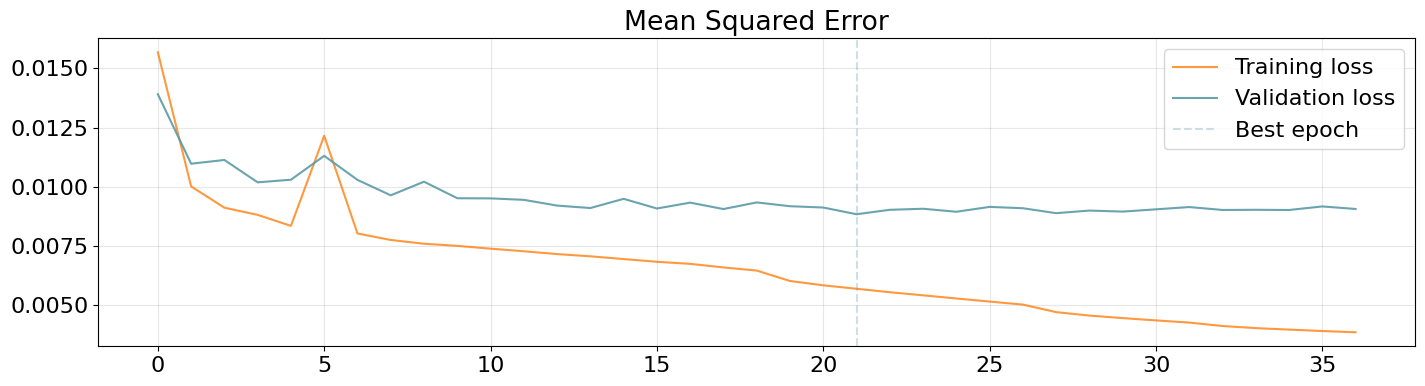

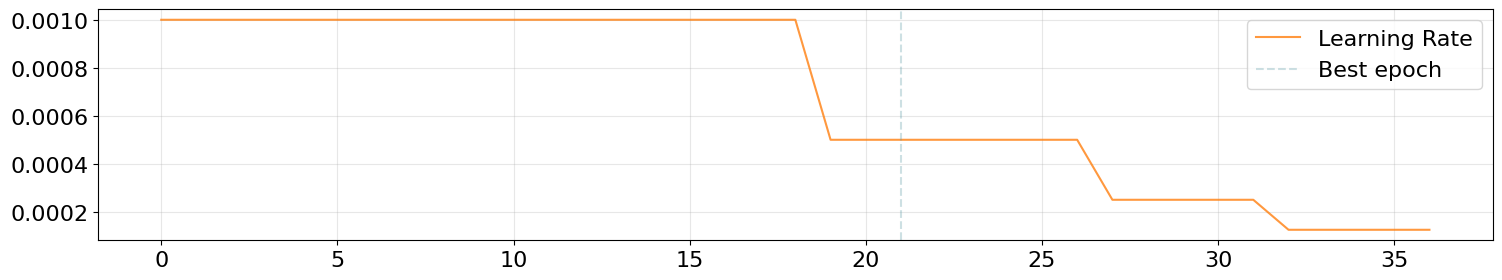

In [53]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17, 4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18, 3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

**Test**

In [54]:
reg_predictions = np.array([])
X_temp = X_test
for reg in range(0, TEL, ATL):
    pred_temp = model.predict(X_temp, verbose=0)
    if (len(reg_predictions) == 0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions, pred_temp), axis=1)
    X_temp = np.concatenate((X_temp[:, ATL:, :], pred_temp), axis=1)

In [55]:
# Print the shape of the predictions
print(f"Predictions shape: {reg_predictions.shape}")
print()

# print("Prediction at 36:")
# mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), reg_predictions.flatten()).numpy()
# print(f"Mean Squared Error: {mean_squared_error}")
# mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), reg_predictions.flatten()).numpy()
# print(f"Mean Absolute Error: {mean_absolute_error}")
# print()

print("Prediction at 18:")
y_test_18 = y_test[:, :18]
reg_predictions_18 = reg_predictions[:, :18]
mean_squared_error = tfk.metrics.mean_squared_error(y_test_18.flatten(), reg_predictions_18.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test_18.flatten(), reg_predictions_18.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")
print()

print("Prediction at 9:")
y_test_9 = y_test[:, :9]
reg_predictions_9 = reg_predictions[:, :9]
mean_squared_error = tfk.metrics.mean_squared_error(y_test_9.flatten(), reg_predictions_9.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test_9.flatten(), reg_predictions_9.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")
print()

Predictions shape: (26794, 18, 1)

Prediction at 18:
Mean Squared Error: 0.008840392343699932
Mean Absolute Error: 0.06245238333940506

Prediction at 9:
Mean Squared Error: 0.005822152364999056
Mean Absolute Error: 0.04966970533132553



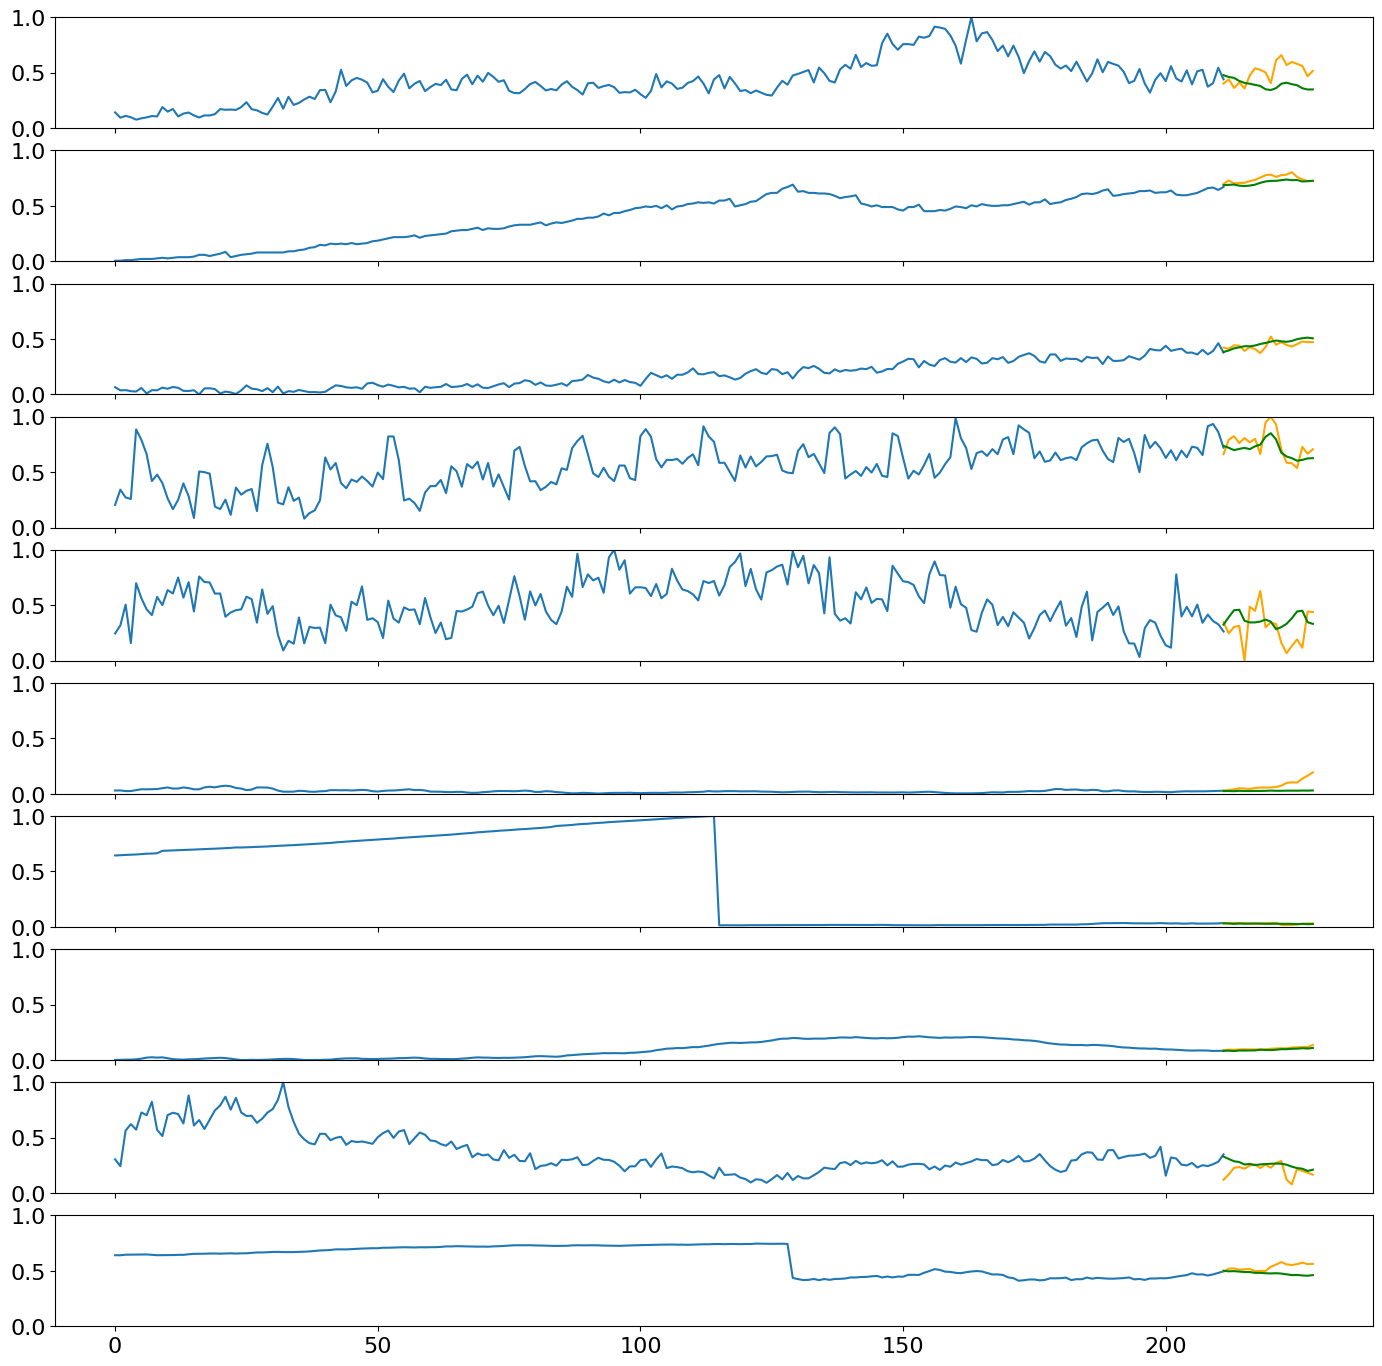

In [57]:
inspect_multivariate_prediction(X_test, y_test, reg_predictions, TEL, 10)

**Save the Model**

In [35]:
NAME_MODEL = "BidirectionalGRU_212_18_18_FlipF_Alex"
if use_tpu:
  # save model locally from tpu using Tensorflow's "SavedModel" format
  save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
  model.save(NAME_MODEL, options=save_locally)
else:
  model.save(NAME_MODEL)

In [36]:
!zip -r {NAME_MODEL}.zip {NAME_MODEL}/

  adding: BidirectionalGRU_212_18_18_FlipF_Alex/ (stored 0%)
  adding: BidirectionalGRU_212_18_18_FlipF_Alex/variables/ (stored 0%)
  adding: BidirectionalGRU_212_18_18_FlipF_Alex/variables/variables.index (deflated 70%)
  adding: BidirectionalGRU_212_18_18_FlipF_Alex/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: BidirectionalGRU_212_18_18_FlipF_Alex/keras_metadata.pb (deflated 93%)
  adding: BidirectionalGRU_212_18_18_FlipF_Alex/saved_model.pb (deflated 91%)
  adding: BidirectionalGRU_212_18_18_FlipF_Alex/assets/ (stored 0%)
  adding: BidirectionalGRU_212_18_18_FlipF_Alex/fingerprint.pb (stored 0%)
